In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


# Imports

In [2]:
import os
import glob
import random
import time
import logging
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Input, Reshape, UpSampling2D, MaxPooling2D, add
from tensorflow.keras.layers import SeparableConv2D, Conv2DTranspose, Dense, Conv2D
from tensorflow.keras.layers import ReLU, Dropout, BatchNormalization, Flatten, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.models import save_model
from tensorflow import device

from sklearn.metrics import confusion_matrix, classification_report

from scipy.spatial.distance import euclidean

from PIL import Image
from PIL import ImageFile

# Enviroment set up

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
IMAGES_PATH = ''
LOG_PATH = ''

logging.basicConfig(filename=LOG_PATH + "std.log", 
                    format='%(asctime)s %(message)s', 
                    filemode='w')
logger=logging.getLogger()
logger.setLevel(logging.CRITICAL)
logging.basicConfig(level=logging.CRITICAL)

# Auxiliary functions 

In [5]:
def get_mean_loss(loss, n_batches):
    num_epochs = int(len(loss)/n_batches)
    mean_loss = []
    
    for i in range(num_epochs):
        mean_loss.append(statistics.mean(loss[i*n_batches:(i+1)*n_batches]))
        
    return mean_loss

In [6]:
def shuffle_four_arrays(a, b, c, d):
    assert len(a) == len(b) and len(a) == len(c) and len(a) == len(d)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p], d[p]

# Model class

In [7]:
class cbir_cnn():

    def __init__(self):
        # Training configuration
        self.n_epochs = 12
        self.batch_size = 32
        self.n_batches = 0
        self.ev_interval_1 = 100
        self.ev_interval_2 = 20000
        self.conf_mat_samples = 100
        
        # Training data
        self.epoch = 0
        self.batch = 0
        self.val_perc = 0.1
        
        # Image dimensions
        self.img_height =  240
        self.img_width = 240
        self.img_channels = 4
        
        # Networks configuration
        self.filters_encoder = [16, 32, 64, 128, 256]
        self.filters_decoder = [256, 128, 64, 32, 16]
        
        self.classifier_perceptron = [64]

        self.latent_dim = 500
        
        # Dataset
        self.X_train = None
        self.X_seg_train = None
        self.y_train = None
        
        self.X_val = None
        self.X_seg_val = None
        self.y_val = None
        
        self.sub_id_train = None
        self.tumour_area_train = None
        self.sub_id_val = None
        self.tumour_area_val = None
        
        # Models
        self.encoder = None
        self.autoencoder = None
        self.classifier = None
        self.composed_model = None
        
        # Training history
        self.history = {
            'loss' : [],
            'val_loss' : [],
            'loss_mean' : [],
            'loss_epoch' : [],

            'reconstruction_output_loss' : [],
            'val_reconstruction_output_loss' : [],
            'reconstruction_output_loss_mean' : [],
            'reconstruction_output_loss_epoch' : [],

            'classification_output_loss' : [],
            'val_classification_output_loss' : [],
            'classification_output_loss_mean' : [],
            'classification_output_loss_epoch' : [],
        }
    
    #### LOAD BRATS DATA FROM ####
    def load_data(self):
        X_load = []
        X_seg_load = []
        y_load = []
        sub_id_load = []
        tumour_area = []

        for i, folder_path in enumerate(glob.glob(IMAGES_PATH + '/*')):
            if i%75==0:
                print(str(i) + ' folders loaded')

            id = folder_path[-3:]

            for img_path in glob.glob(folder_path + '/*flair*.png'):
                img = Image.open(img_path)
                img_array = np.array(img)
                img_array = np.expand_dims(img_array, axis=0)
                
                img_array = np.append(img_array, [np.array(Image.open(img_path[:74] + 't1' + img_path[-8:]))], axis=0)
                img_array = np.append(img_array, [np.array(Image.open(img_path[:74] + 't1ce' + img_path[-8:]))], axis=0)
                img_array = np.append(img_array, [np.array(Image.open(img_path[:74] + 't2' + img_path[-8:]))], axis=0)
                
                img_array = np.rollaxis(img_array, 0, 3)
                X_load.append(img_array)
                
                path = img_path[:74] + 'hemi' + img_path[-8:]
                if os.path.exists(path):
                    img = Image.open(path)
                    img_array = np.array(img)
                    X_seg_load.append(img_array)
                else:
                    X_seg_load.append(None)

                y_path = img_path[:74] + 'seg' + img_path[-8:]
                img = Image.open(y_path)
                img_array = np.array(img)
                y_load.append(img_array)

                sub_id_load.append(id)
                tumour_area.append(self.get_tum_area(img_array))

        # Input image scanner
        X_train_aux = np.asarray(X_load[int(self.val_perc * len(X_load)):])
        X_train_aux = X_train_aux/127.5 - 1
        self.X_train = X_train_aux
        
        X_val_aux = np.asarray(X_load[:int(self.val_perc * len(X_load))])
        X_val_aux = X_val_aux/127.5 - 1
        self.X_val = X_val_aux
        
        # Segmented anatomical labels
        X_seg_train_aux = np.asarray(X_seg_load[int(self.val_perc * len(X_seg_load)):])
        self.X_seg_train = X_seg_train_aux
        
        X_seg_val_aux = np.asarray(X_seg_load[:int(self.val_perc * len(X_seg_load))])
        self.X_seg_val = X_seg_val_aux
        
        # Tumour presence labels
        y_train_aux = np.asarray(y_load[int(self.val_perc * len(y_load)):])
        y_train_aux = y_train_aux/64
        self.y_train = y_train_aux
        
        y_val_aux = np.asarray(y_load[:int(self.val_perc * len(y_load))])
        y_val_aux = y_val_aux/64
        self.y_val = y_val_aux
        
        # Patient id
        self.sub_id_train = np.asarray(sub_id_load[int(self.val_perc * len(sub_id_load)):])
        self.sub_id_val = np.asarray(sub_id_load[:int(self.val_perc * len(sub_id_load))])
        
        # Tumoural area
        self.tumour_area_train = np.asarray(tumour_area[int(self.val_perc * len(tumour_area)):])
        self.tumour_area_val = np.asarray(tumour_area[:int(self.val_perc * len(tumour_area))])
    
    def load_labels(self, y):
        labels = []
        for img in y:
            if np.amax(img) > 0:
                labels.append(1)
            else:
                labels.append(0)
                
        return np.asarray(labels)
    
    def get_tum_area(self, img_array):
        return np.count_nonzero(img_array > 0)
    
    #### NETWORK GENERATION ####
    
    def create_res_block(self, input_layer, filters, kernel_size):
        x = input_layer
        for i in range(2):
            x = BatchNormalization()(x)
            x = ReLU()(x)
            x = Dropout(0.3)(x)
            x = SeparableConv2D(filters, kernel_size=kernel_size, strides=1, padding="same")(x)

        # Match num of filters
        y = SeparableConv2D(filters, kernel_size=(1,1), strides=1, padding="same")(input_layer)
            
        x = add([x, y])
        return x
    
    def create_encoder(self, input_img):
        x = input_img
        
        # Downsize layers
        for i in range(len(self.filters_encoder)):
            if i != 0:
                x = MaxPooling2D(3, strides=2, padding="same")(x)
            x = self.create_res_block(x, self.filters_encoder[i], kernel_size=3)

        # Latent dimension      
        x = Flatten()(x)
        x = Dense(self.latent_dim)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Dropout(0.3)(x)
        return x
    
    def create_decoder(self, latent_space):
        # From latent space to image
        x = Dense(15*15*256)(latent_space)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Dropout(0.3)(x)
        x = Reshape((15, 15, 256))(x)

        # Upsampling layers
        for i in range(len(self.filters_decoder)):
            if i != 0:
                x = UpSampling2D(2)(x)
            x = self.create_res_block(x, self.filters_decoder[i], kernel_size=3)
        
        # Output image generation
        x = SeparableConv2D(self.img_channels, kernel_size=1, strides=1, padding="same",
                            activation='tanh', name='reconstruction_output')(x)
        return x
    
    def create_classifier(self, latent_dim):
        # Perceptron layers
        x = Flatten()(latent_dim)
        
        for n_neurons in self.classifier_perceptron:
            x = Dense(n_neurons)(x)
            x = BatchNormalization()(x)
            x = ReLU()(x)
            x = Dropout(0.3)(x)

        # Classification
        x = Dense(1, activation='sigmoid', name='classification_output')(x)
        return x
    
    def create_models(self):
        input_img = Input(shape=(self.img_height,
                                 self.img_width,
                                 self.img_channels))

        # Encoder generation
        latent_space = self.create_encoder(input_img)
        self.encoder = Model(input_img, latent_space)

        # Decoder generation
        output_img = self.create_decoder(latent_space)
        self.autoencoder = Model(input_img, output_img)

        # Classifier generation
        classification = self.create_classifier(latent_space)
        self.classifier = Model(input_img, classification)

        # Ensemble generation
        self.composed_model = Model(input_img, [output_img, classification])
        
    #### PLOTTING FUNCTIONS ####
    
    def plot_reconstruction(self, n_plots, original_imgs, reconstructed_img_predictions):
        # Define figure
        f, axarr = plt.subplots(n_plots, 2, figsize=(8, 3*n_plots))
        plt.suptitle('Epoch: ' + str(self.epoch) + ', Batch: ' + str(self.batch), fontsize=16)

        axarr[0,0].set_title('Source image')
        axarr[0,1].set_title('Reconstructed image')

        # Plot each reconstruction
        for i in range(n_plots):
            axarr[i,0].imshow(original_imgs[i,:,:,0], cmap='gray')
            axarr[i,1].imshow(reconstructed_img_predictions[i,:,:,0], cmap='gray')

            axarr[i,0].get_xaxis().set_visible(False)
            axarr[i,0].get_yaxis().set_visible(False)
            axarr[i,1].get_xaxis().set_visible(False)
            axarr[i,1].get_yaxis().set_visible(False)

        # Save figure
        plt.savefig(LOG_PATH + 'reconstructions/e' + str(self.epoch).zfill(3) + 'b'
                    + str(self.batch).zfill(5) + '_reconstructed_image.png')
        plt.show()
        
    def plot_train_val(self, loss_name=''):
        # X axis definition
        x_axis = range(len(self.history[loss_name + 'loss']))
        x_axis_mean = range(0, len(self.history[loss_name + 'loss_mean']))

        # Define figure
        plt.rcParams['figure.figsize'] = [20, 5]
        f, ax = plt.subplots(1, 2, sharex=False, sharey=False)
        f.suptitle(loss_name)

        # Plot complete loss figure
        ax[0].plot(x_axis, self.history[loss_name + 'loss'], label='Train Loss')
        ax[0].plot(x_axis, self.history['val_' + loss_name + 'loss'], label='Validation Loss')
        ax[0].set_title('Loss')
        ax[0].set_xlabel('iteration')
        ax[0].legend(loc="upper right")
        ax[0].grid()

        # Plot boxplot for each epoch figure
        ax[1].plot(x_axis_mean, self.history[loss_name + 'loss_mean'])
        ax[1].boxplot(self.history[loss_name + 'loss_epoch'], positions=x_axis_mean, showfliers=False)
        ax[1].set_title('Mean Loss')
        ax[1].set_xlabel('epoch')
        ax[1].legend(loc="upper right")
        ax[1].grid()

        # Save figure
        plt.savefig(LOG_PATH + loss_name + 'train_losses.png')
        plt.show()
        
    def get_mean_loss(self, loss_name):
        n_batches = int(len(self.X_train) / self.batch_size)
        
        epoch_loss = np.split(np.array(self.history[loss_name]), int(len(np.array(self.history[loss_name]))/n_batches))
        mean_loss = get_mean_loss(self.history[loss_name], n_batches)

        self.history[loss_name + '_epoch'] = epoch_loss
        self.history[loss_name + '_mean'] = mean_loss
        
    def conf_matrix(self, y_real, y_pred):
        # Define figure
        f, ax = plt.subplots(2, 1, figsize=(5, 10))
        f.suptitle('Epoch: ' + str(self.epoch) + ', Batch: ' + str(self.batch), fontsize=16)

        # Plot conf matrix for each class
        conf_matrix = confusion_matrix(y_real, y_pred)
        sns.heatmap(conf_matrix, annot=True,
                    cmap='Blues', fmt = 'd', ax=ax[0], cbar=False)

        ax[1].set_xlim((0,1))
        ax[1].set_ylim((0,1))
        ax[1].text(0.5, 0.5, classification_report(y_real, y_pred), ha='center', va='center')
        ax[1].axis('off')

        # Save figure
        plt.savefig(LOG_PATH + 'conf_matrix/e' + str(self.epoch).zfill(3) + 'b'
                    + str(self.batch).zfill(5) + '_confusion_matrix.png')
        plt.show()
    
    #### TRAINING ####
    
    def train(self):      
        print('-----COMPILING MODEL-----')
        losses = {
            "reconstruction_output": "mse",
            "classification_output": "binary_crossentropy",
        }

        loss_weights = {
            "reconstruction_output": 0.2,
            "classification_output": 0.8
        }
        
        self.composed_model.compile(loss=losses, loss_weights=loss_weights,
                                    optimizer=Adam()
                                   )
        
        self.X_train, self.y_train, self.sub_id_train, self.tumour_area_train = shuffle_four_arrays(self.X_train, self.y_train,
                                                                            self.sub_id_train, self.tumour_area_train)
        self.X_val, self.y_val, self.sub_id_val, self.tumour_area_val = shuffle_four_arrays(self.X_val, self.y_val,
                                                                            self.sub_id_val, self.tumour_area_val)
        
        print('-----TRAIN START-----')
        with device('/GPU:1'):
            for epoch in range(self.n_epochs):
                self.epoch = epoch
                logger.critical('='*5 + 'EPOCH ' + str(epoch)  + '='*5)
                start = time.time()

                n_batches = int(len(self.X_train) / self.batch_size)
                for batch in range(n_batches):
                    self.batch = batch
                    X = self.X_train[batch*self.batch_size:(batch+1)*self.batch_size]
                    y_imgs = self.y_train[batch*self.batch_size:(batch+1)*self.batch_size]
                    y_labels = self.load_labels(y_imgs)
                    
                    losses = self.composed_model.train_on_batch(x=X,
                                                                y={"reconstruction_output": X,
                                                                   "classification_output": y_labels},
                                                                return_dict=True)
                    self.history['loss'].append(losses['loss'])
                    self.history['reconstruction_output_loss'].append(losses['reconstruction_output_loss'])
                    self.history['classification_output_loss'].append(losses['classification_output_loss'])
                    
                    idx = np.random.randint(0, len(self.X_val) / self.batch_size)
                    X_val = self.X_val[idx*self.batch_size:(idx+1)*self.batch_size]
                    y_imgs = self.y_val[idx*self.batch_size:(idx+1)*self.batch_size]
                    y_labels = self.load_labels(y_imgs)
                    
                    val_losses = self.composed_model.test_on_batch(x=X_val,
                                                               y={"reconstruction_output": X_val,
                                                                  "classification_output": y_labels},
                                                               return_dict=True)
                    self.history['val_loss'].append(val_losses['loss'])
                    self.history['val_reconstruction_output_loss'].append(val_losses['reconstruction_output_loss'])
                    self.history['val_classification_output_loss'].append(val_losses['classification_output_loss'])

                    if batch % self.ev_interval_1 == 0:
                        logger.critical('Epoch: ' + str(self.epoch) +
                                        ' \tBatch ' + str(self.batch) + ': ' + str(losses))

                    if batch % self.ev_interval_2 == 0:
                        # Reconstruction evaluation
                        n_plots = 3
                        self.plot_reconstruction(n_plots, self.X_val[:n_plots],
                                                 self.autoencoder.predict(self.X_val[:n_plots]))
                        
                        # Confusion matrix evaluation
                        y_real_imgs = self.y_val[:self.conf_mat_samples]
                        y_real = self.load_labels(y_real_imgs)
                        y_pred = self.classifier.predict(self.X_val[:self.conf_mat_samples])
                        self.conf_matrix(y_real, np.around(y_pred, 0))

                self.get_mean_loss('loss')
                self.get_mean_loss('reconstruction_output_loss')
                self.get_mean_loss('classification_output_loss')

                self.plot_train_val()
                self.plot_train_val('reconstruction_output_')
                self.plot_train_val('classification_output_')

                end = time.time()
                logger.critical('Epoch time ' + str(end-start))
                start = time.time()
                
                # Saving models
                logger.critical('Saving models')
                self.encoder.save(LOG_PATH + 'models/e' + str(self.epoch).zfill(3) + '_encoder.h5')
                self.autoencoder.save(LOG_PATH  + 'models/e' + str(self.epoch).zfill(3) + '_autoencoder.h5')
                self.classifier.save(LOG_PATH  + 'models/e' + str(self.epoch).zfill(3) + '_classifier.h5')
                self.composed_model.save(LOG_PATH  + 'models/e' + str(self.epoch).zfill(3) + '_composed_model.h5')

In [8]:
cbir = cbir_cnn()

In [9]:
cbir.load_data()

0 folders loaded
75 folders loaded
150 folders loaded
225 folders loaded
300 folders loaded


In [10]:
cbir.create_models()

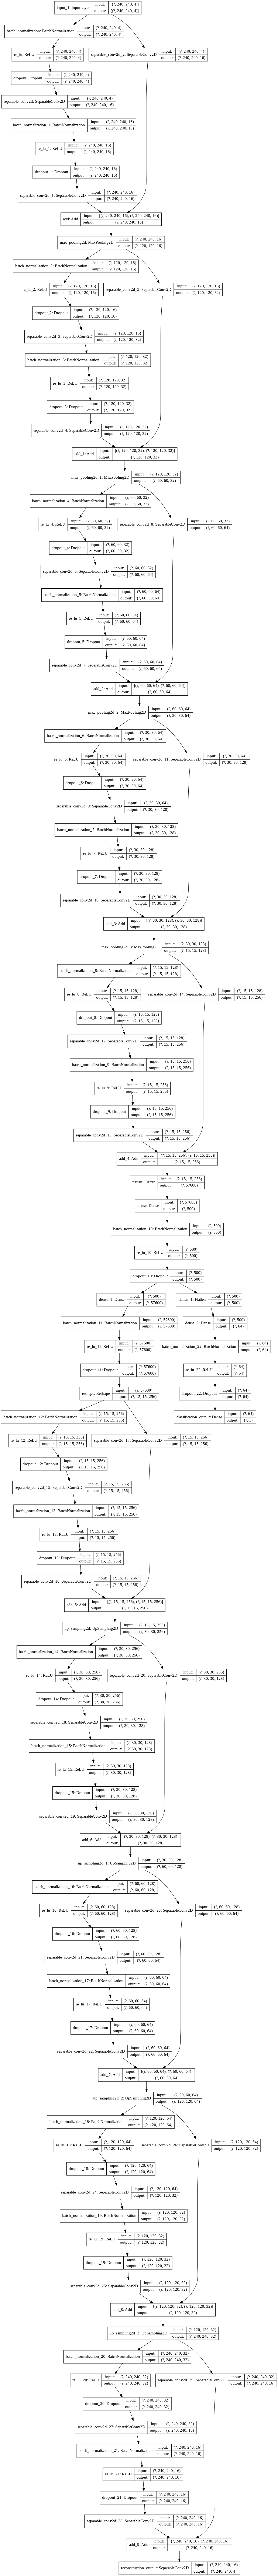

In [11]:
plot_model(cbir.composed_model, show_shapes=True)

-----COMPILING MODEL-----
-----TRAIN START-----


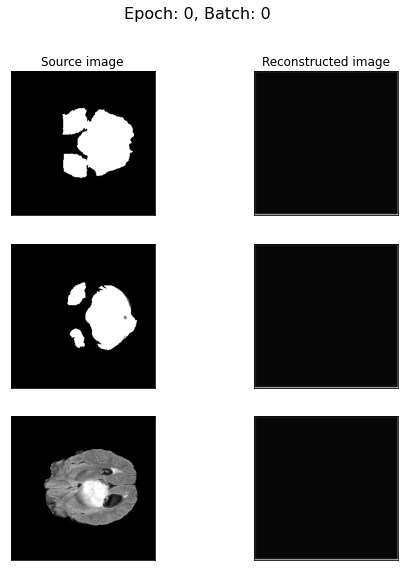

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


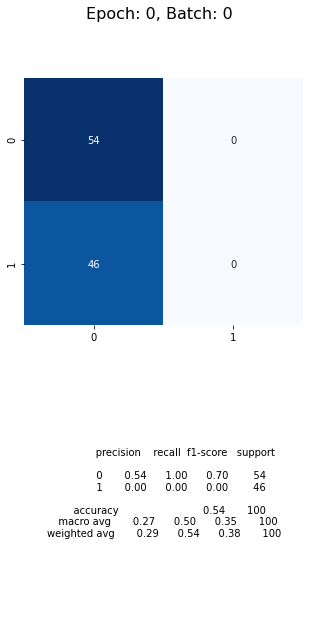

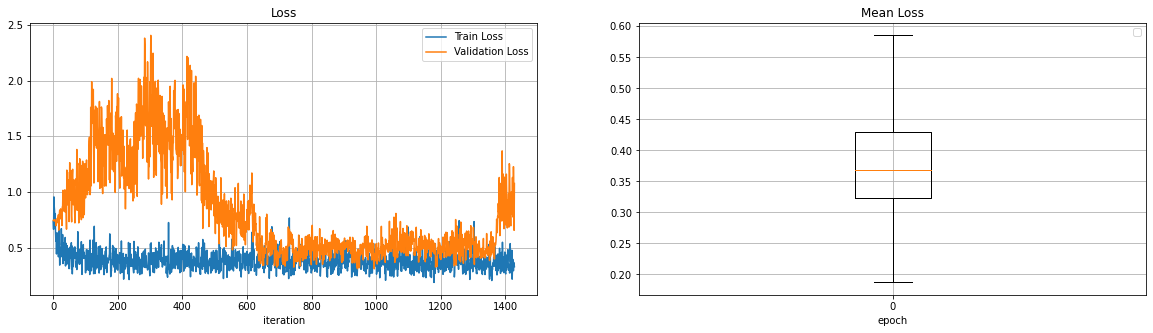

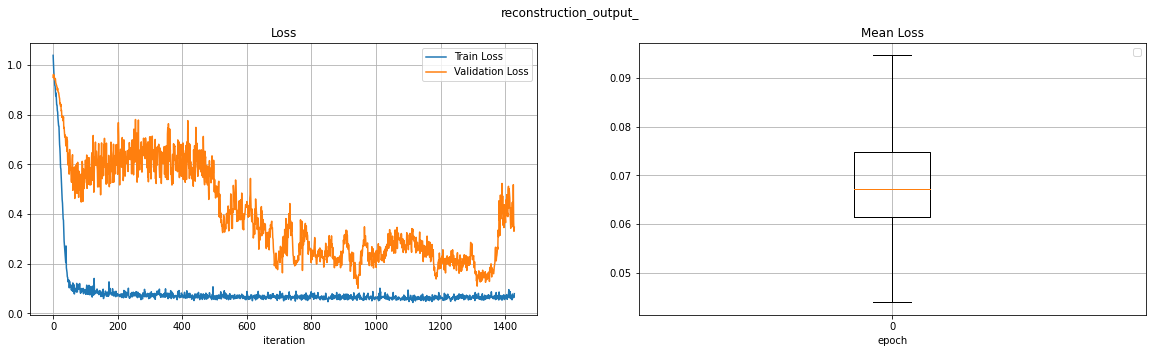

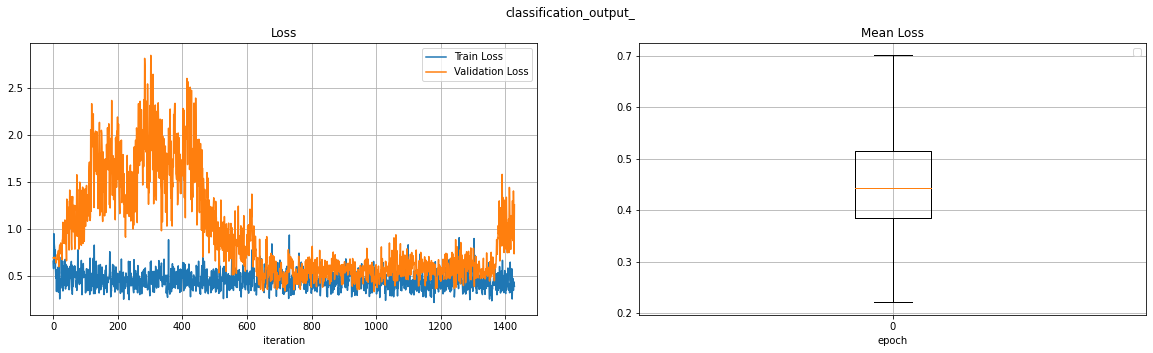

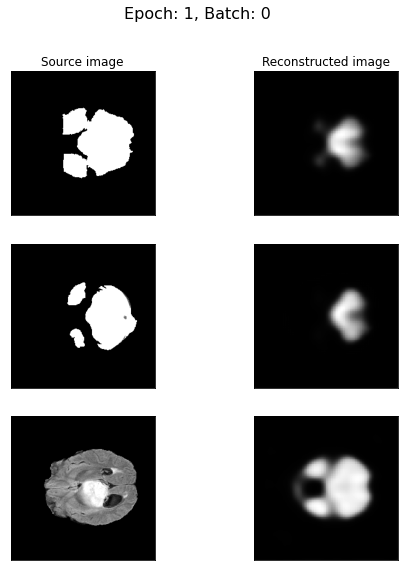

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


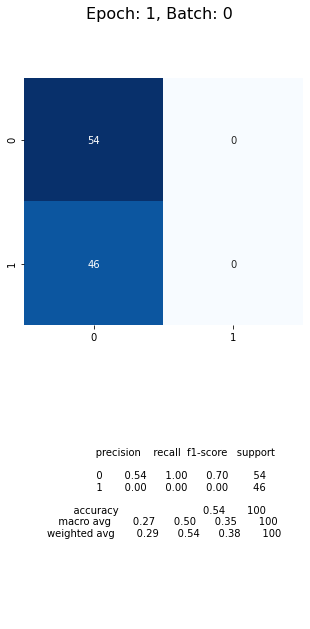

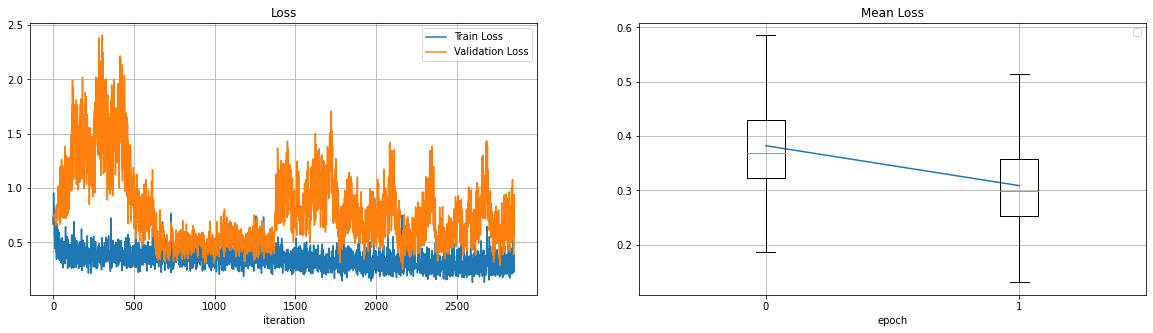

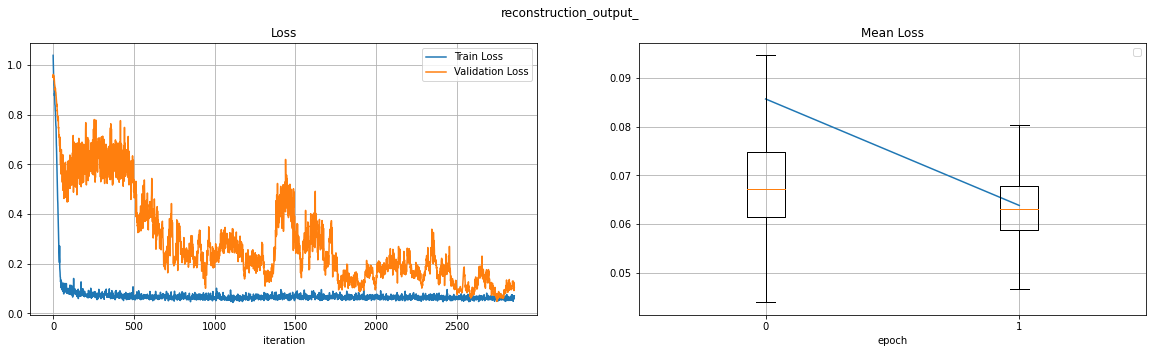

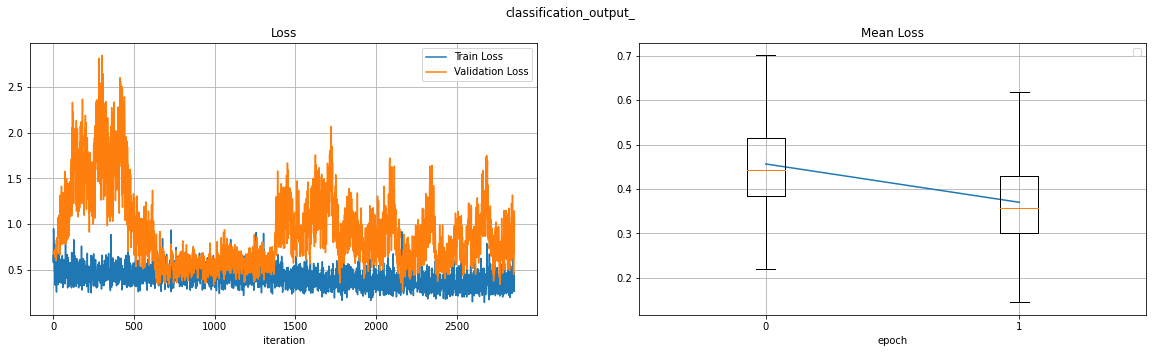

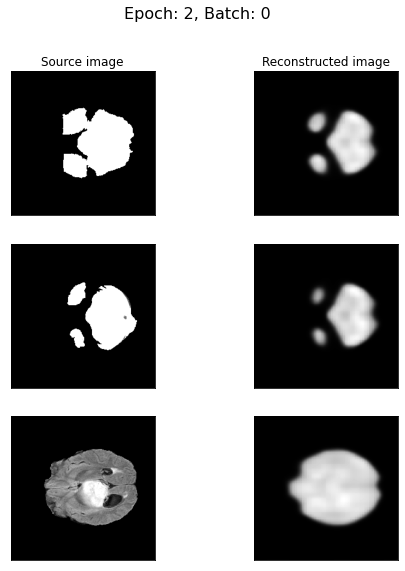

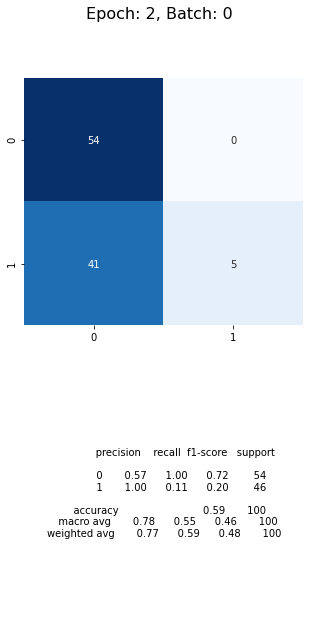

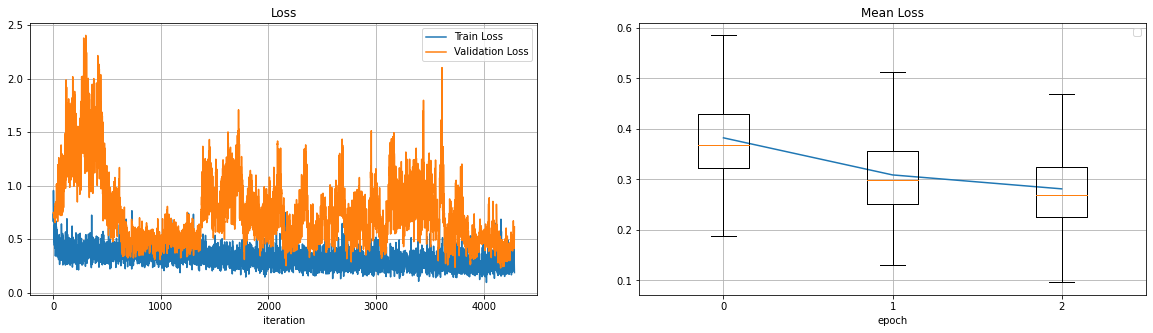

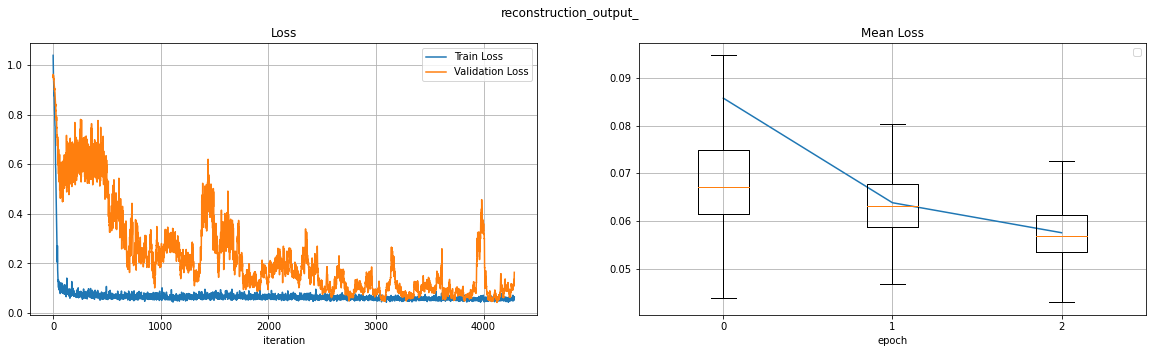

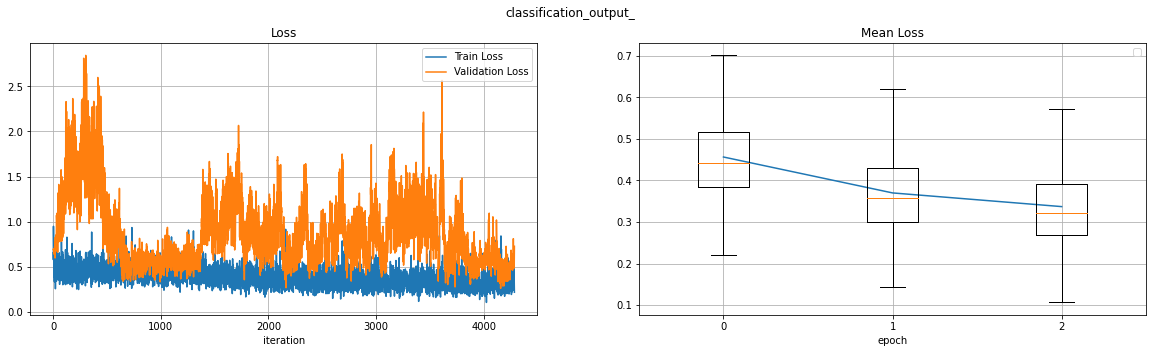

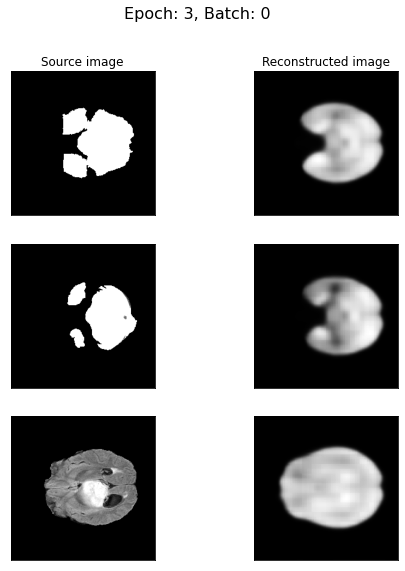

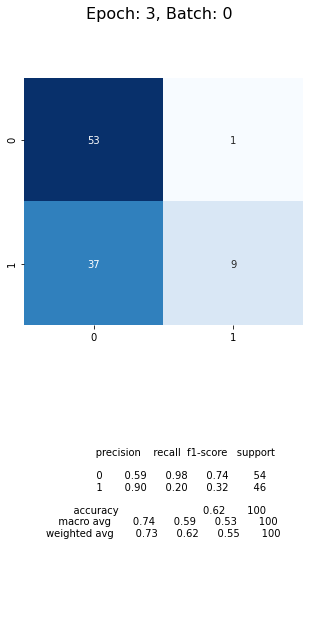

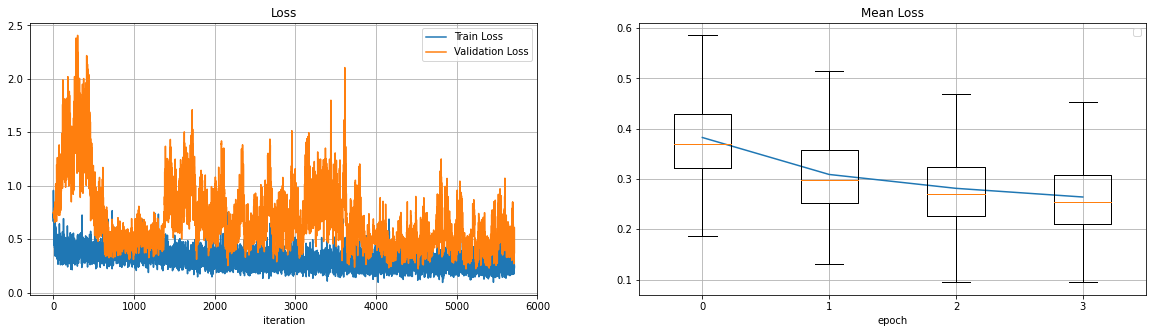

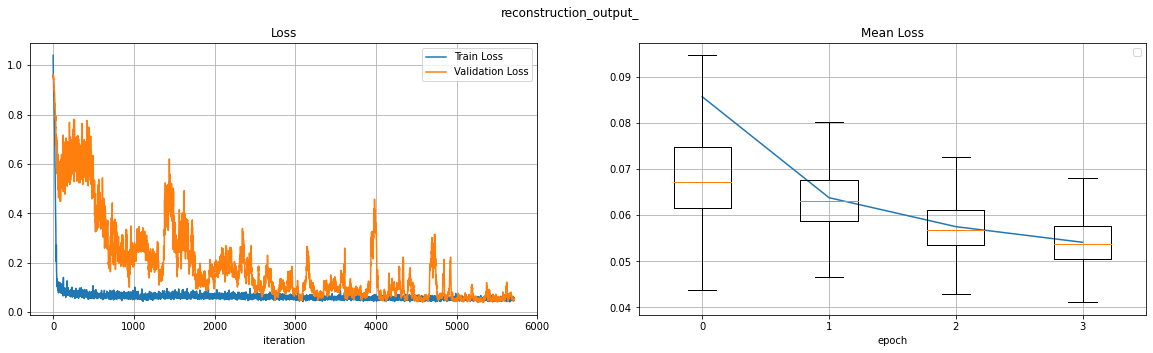

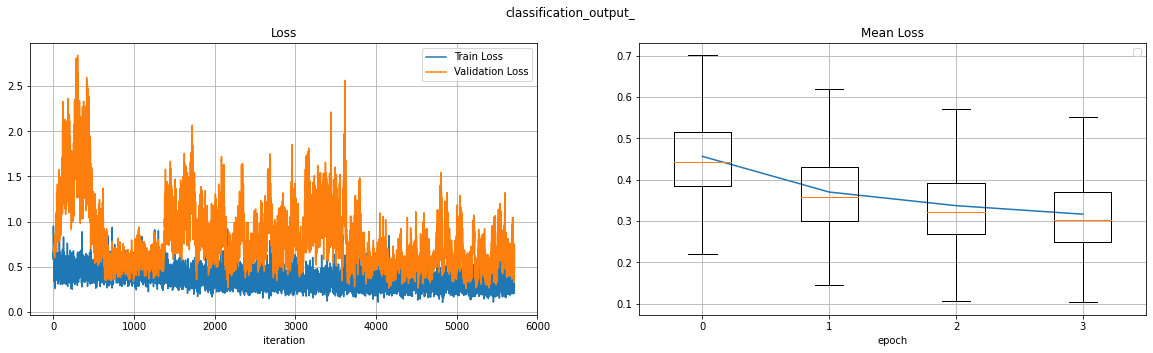

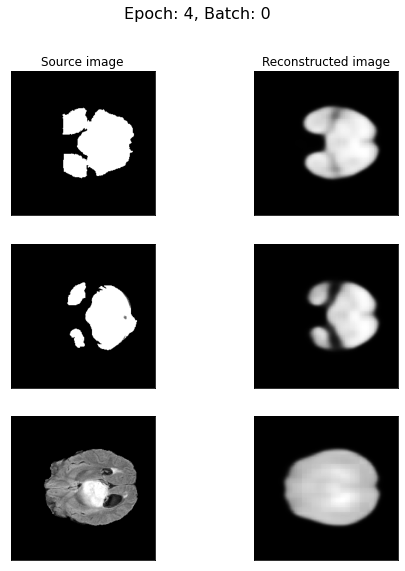

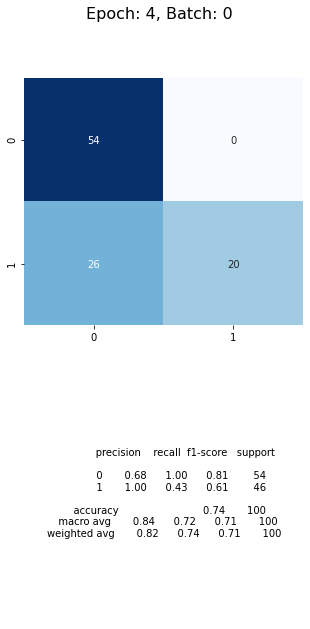

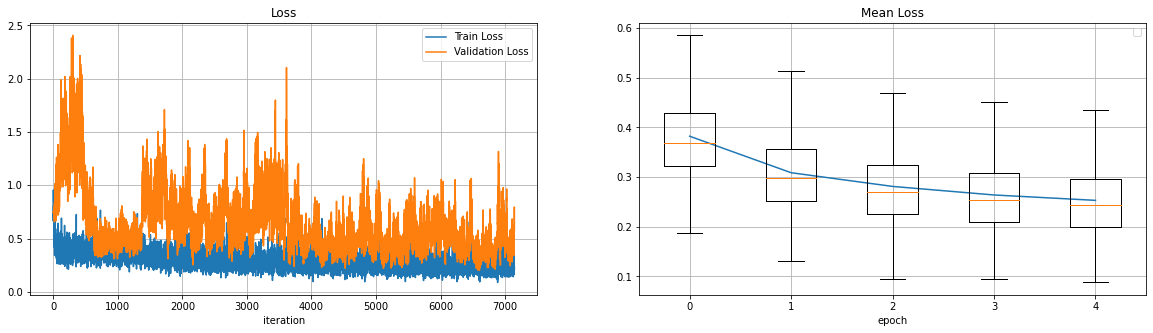

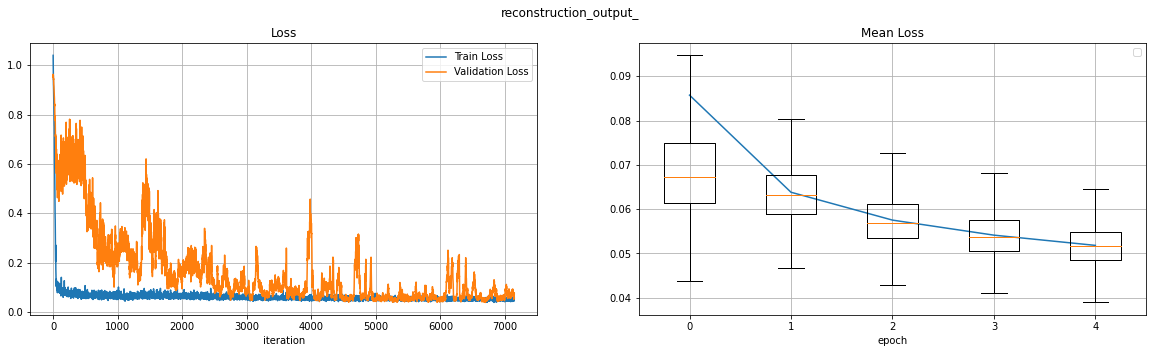

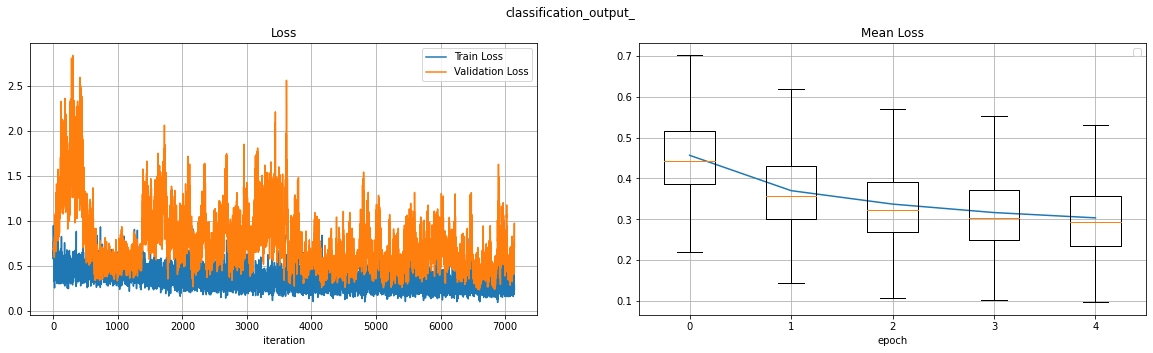

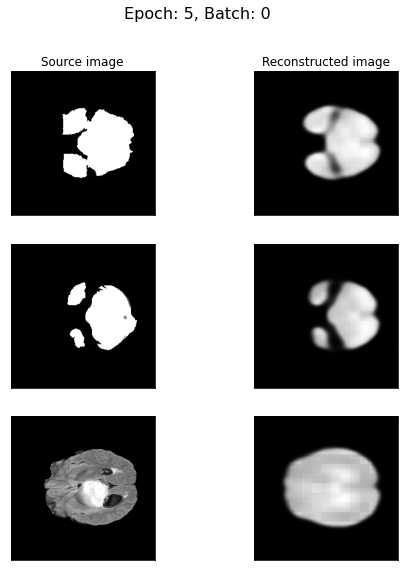

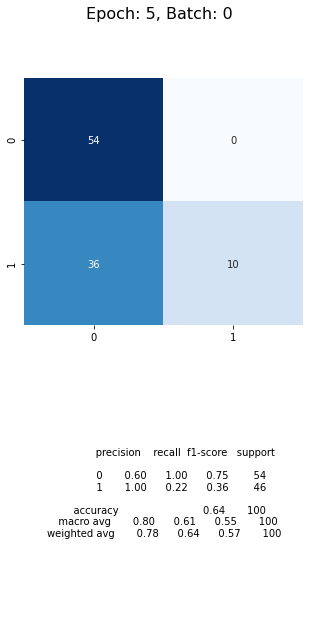

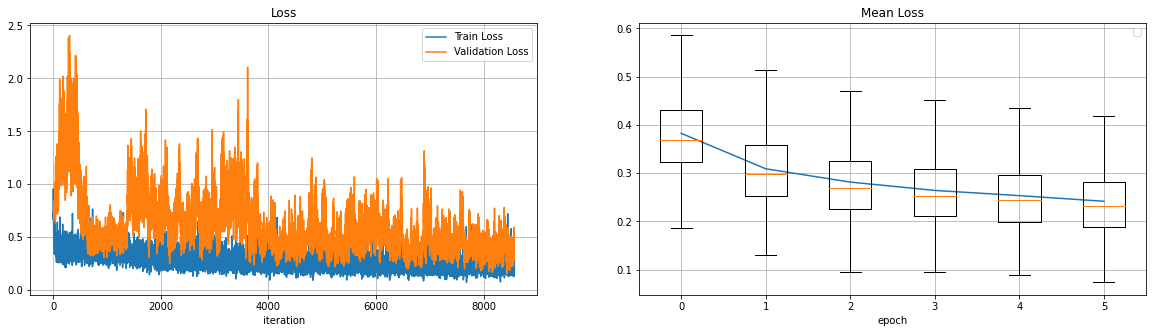

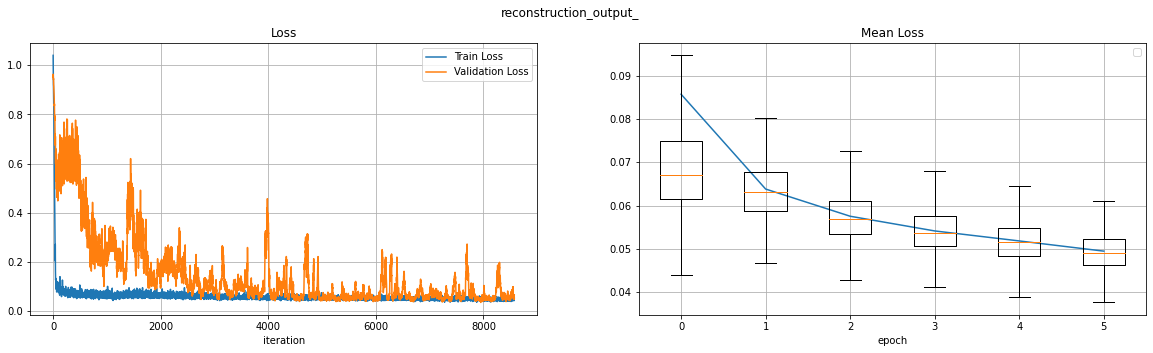

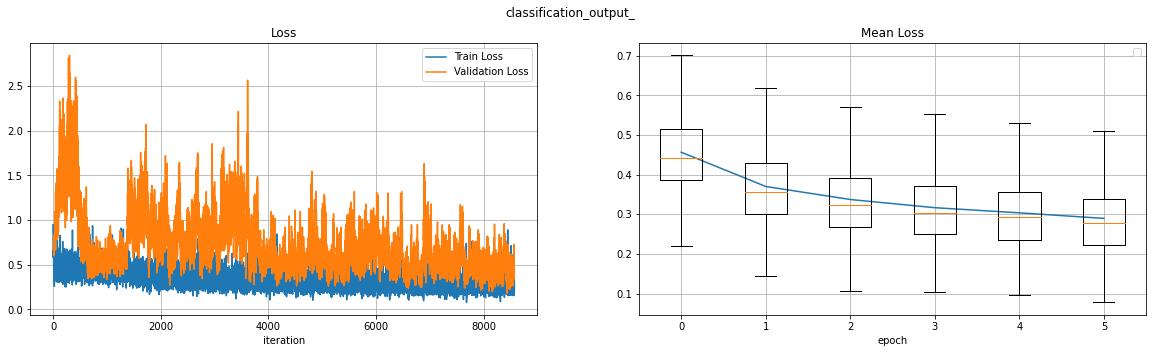

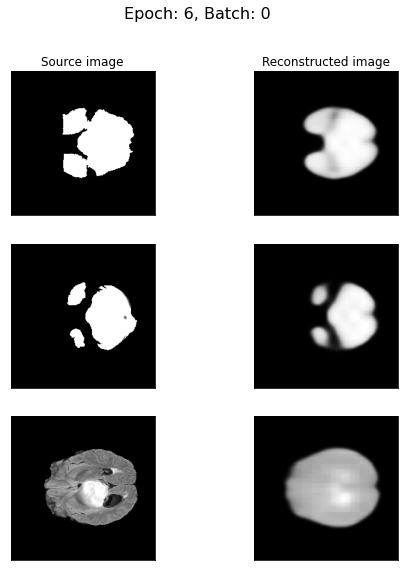

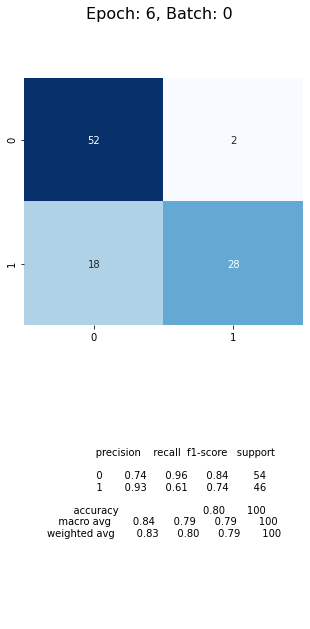

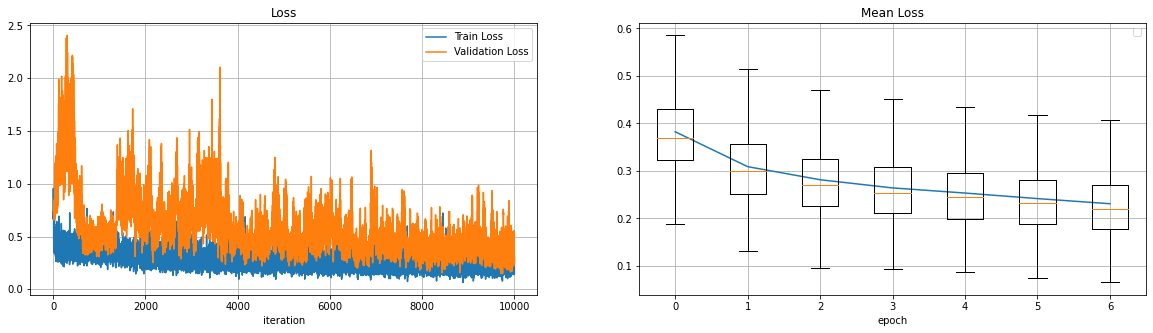

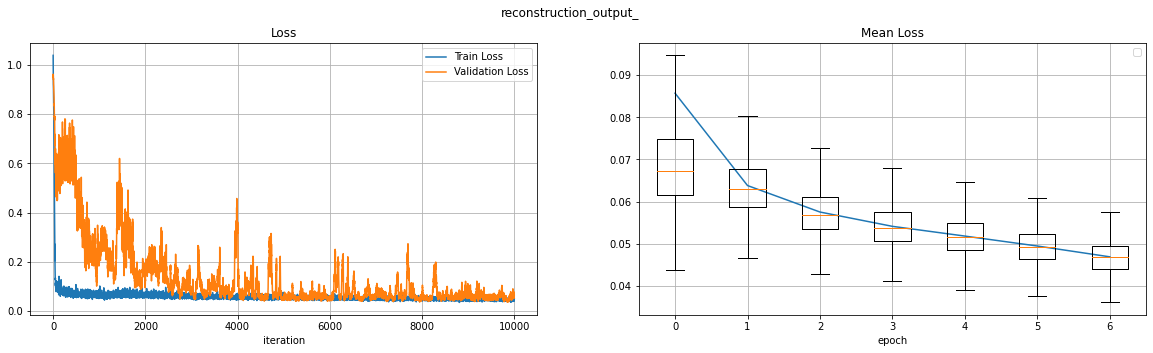

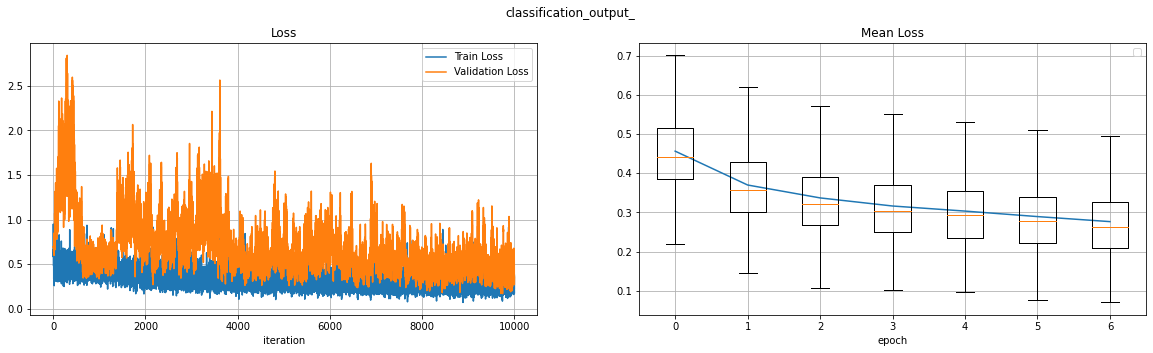

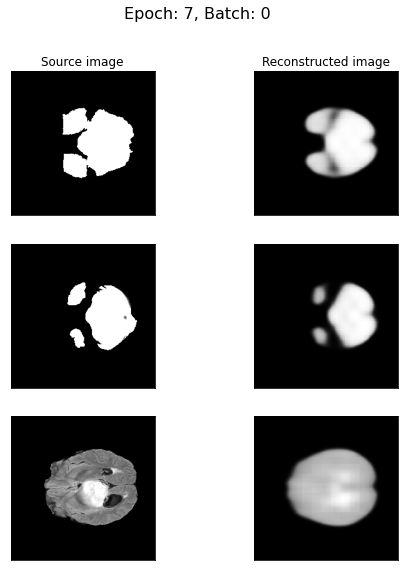

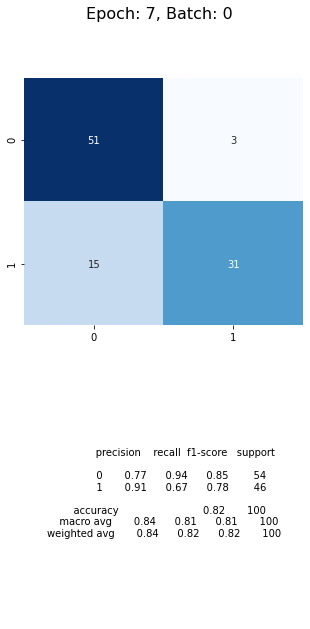

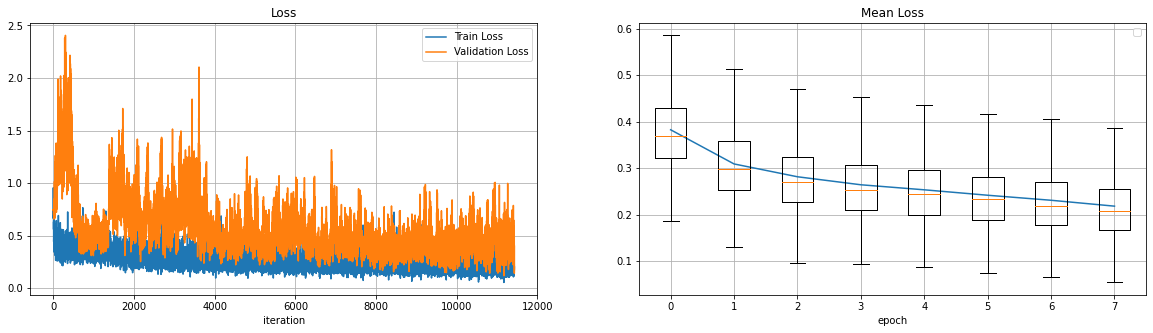

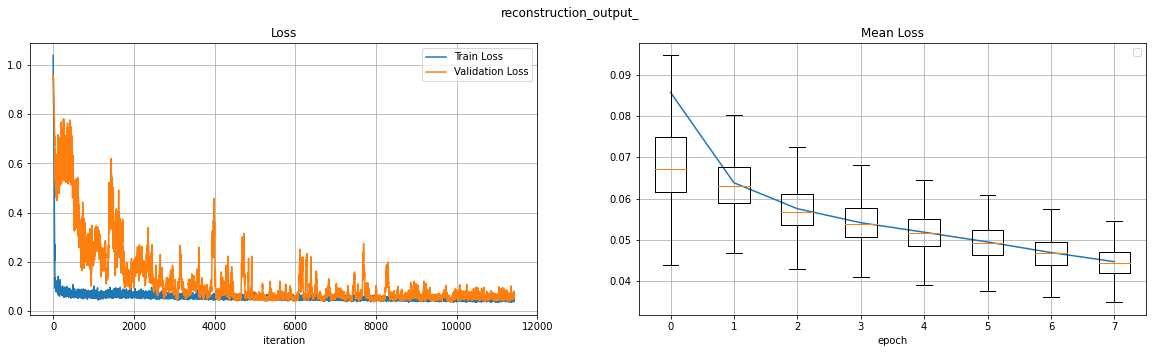

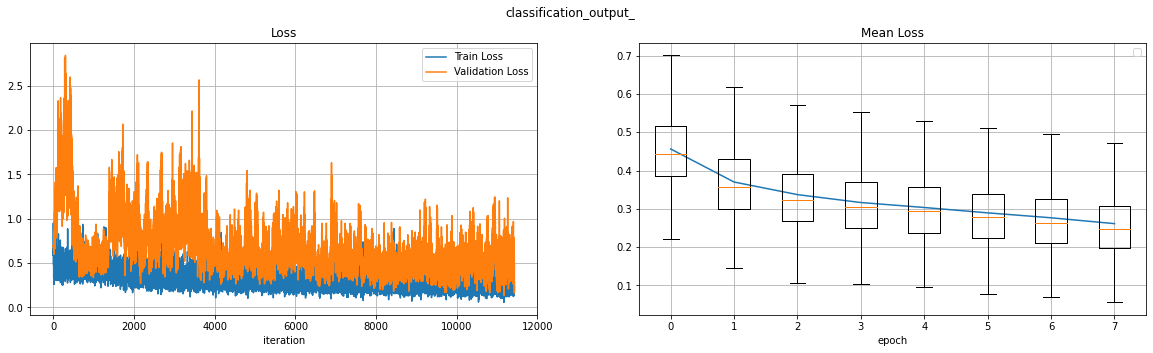

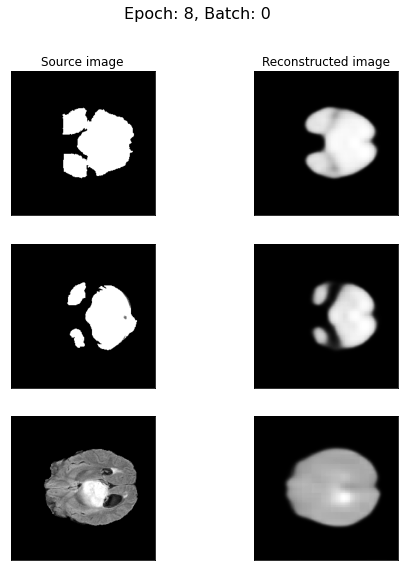

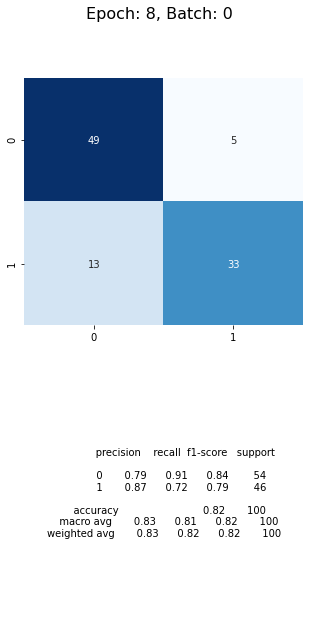

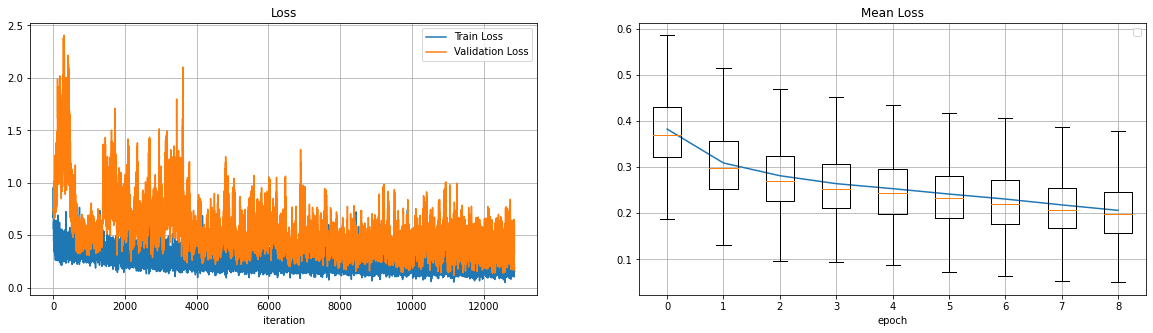

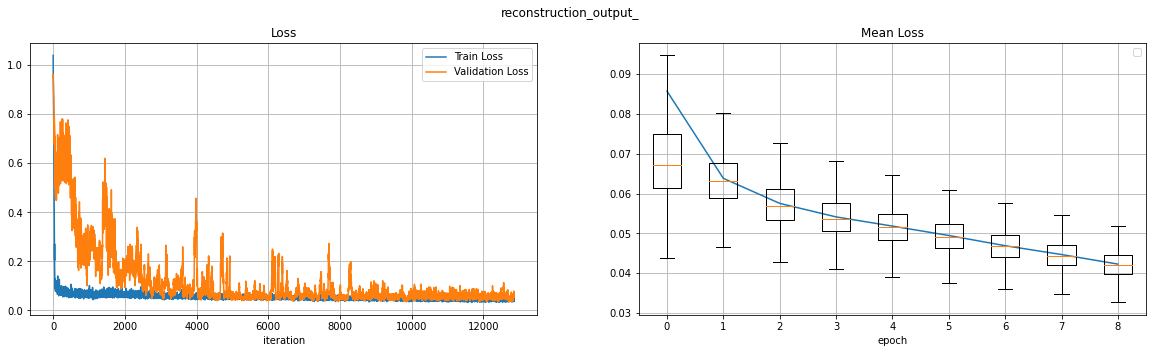

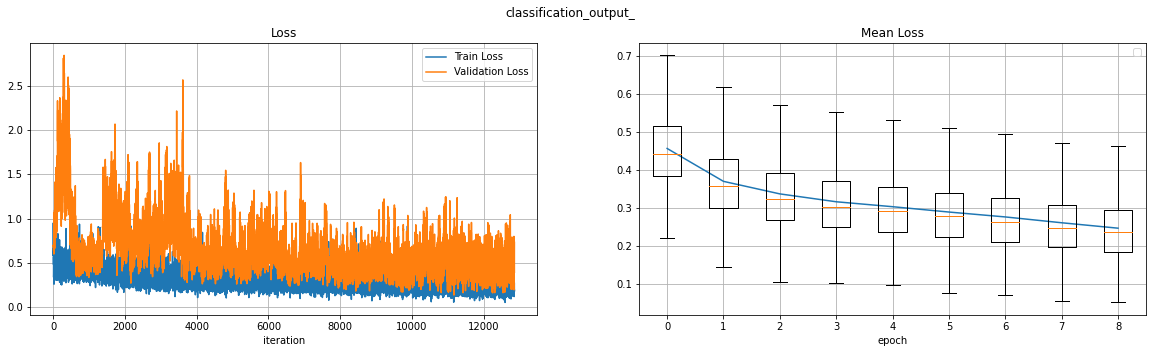

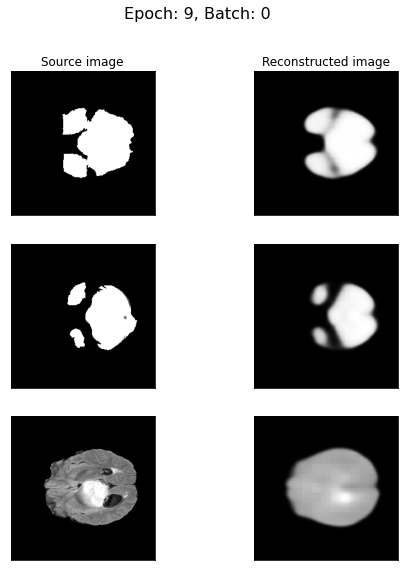

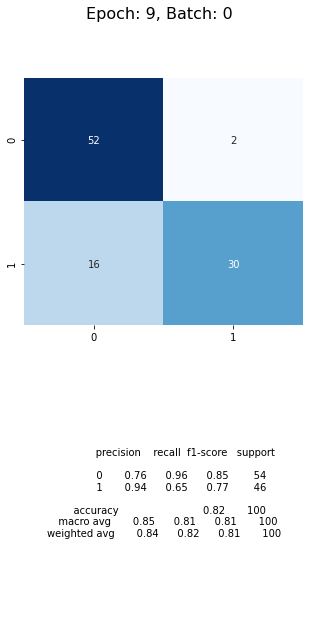

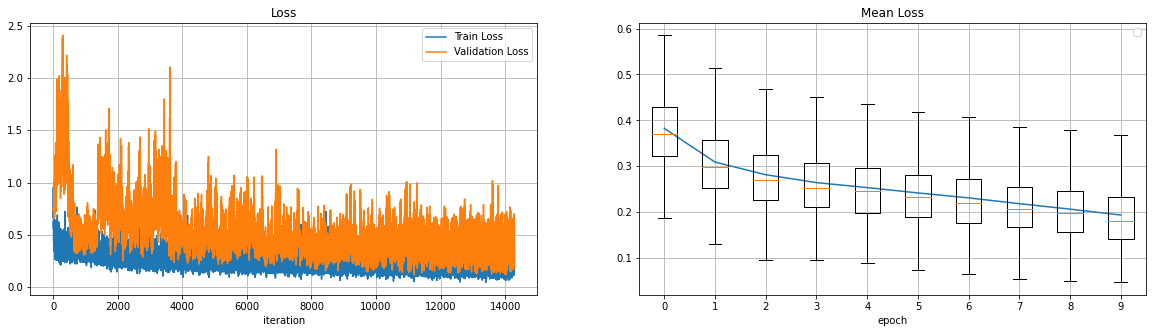

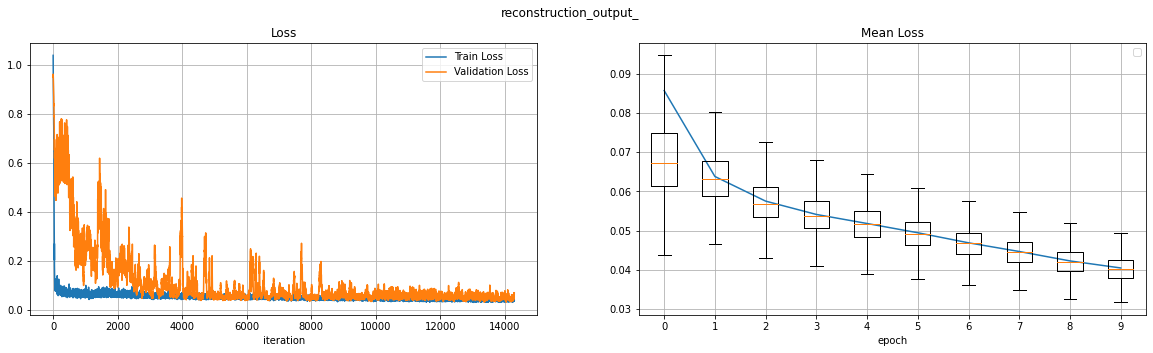

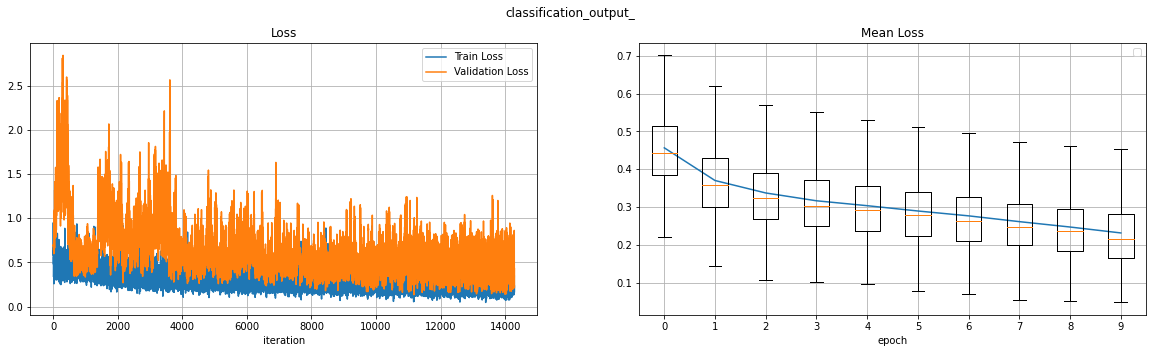

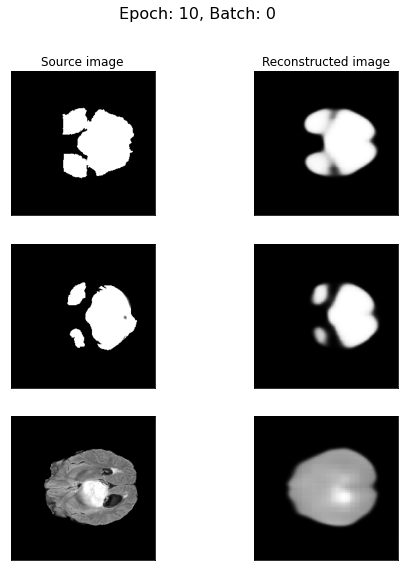

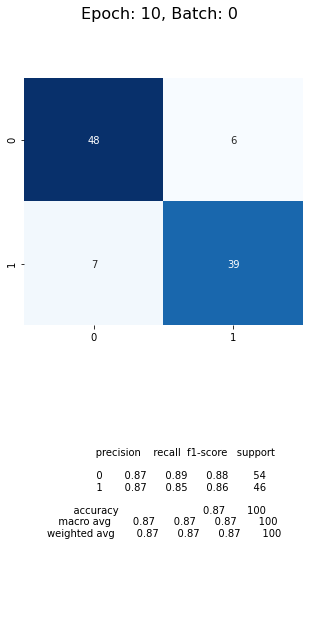

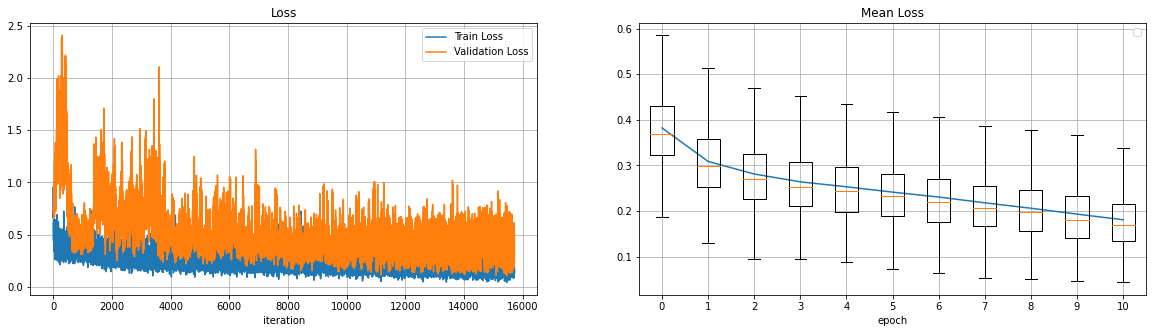

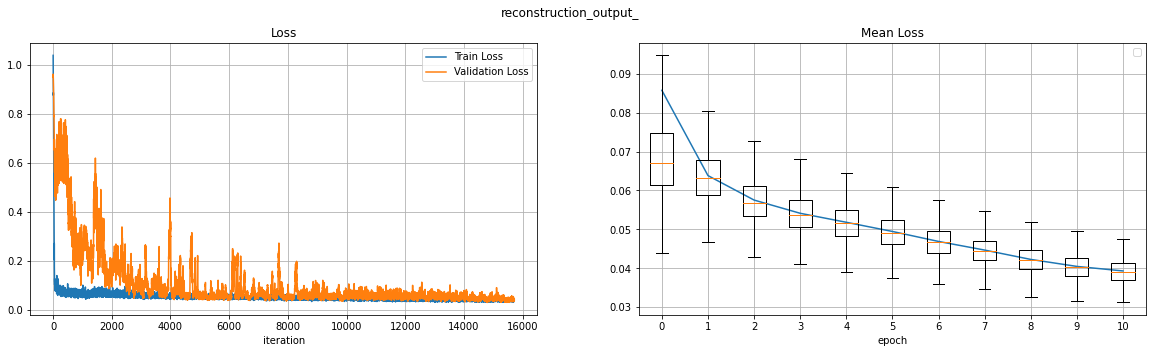

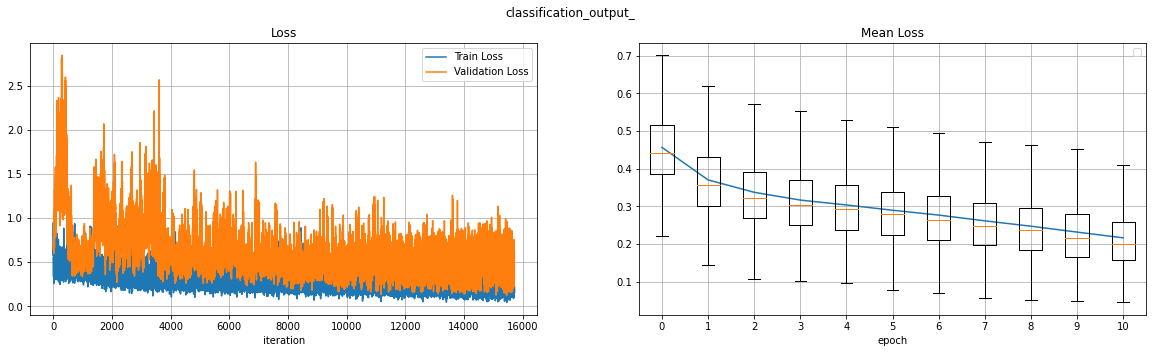

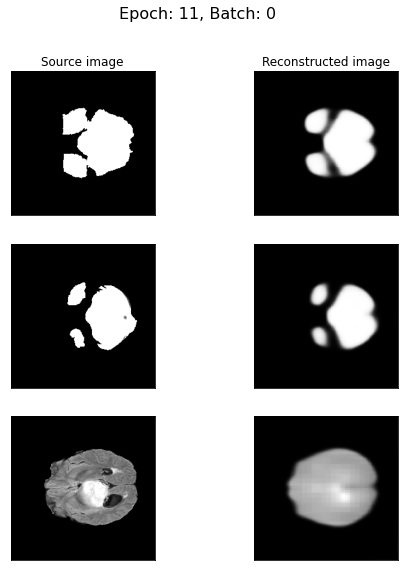

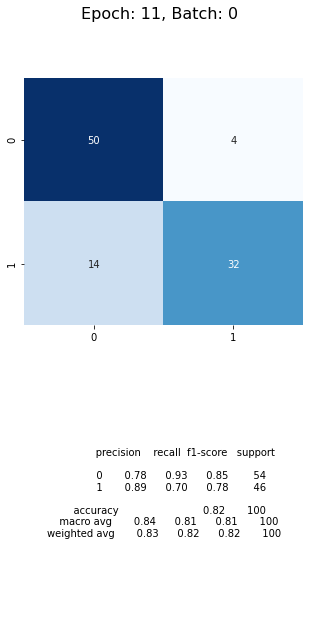

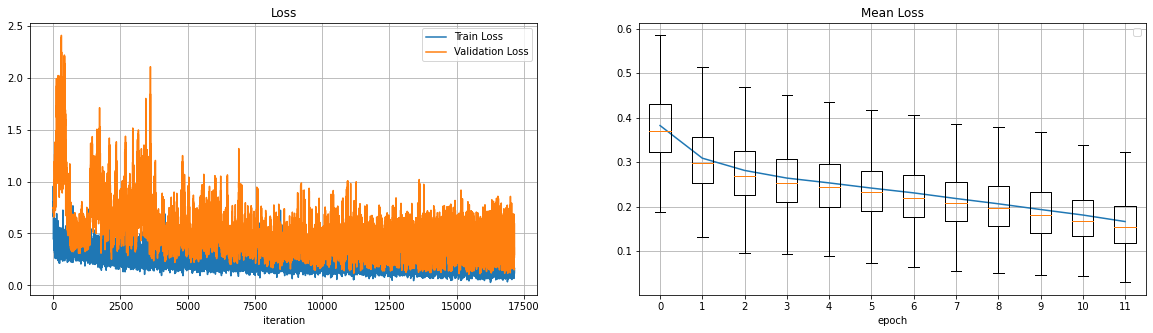

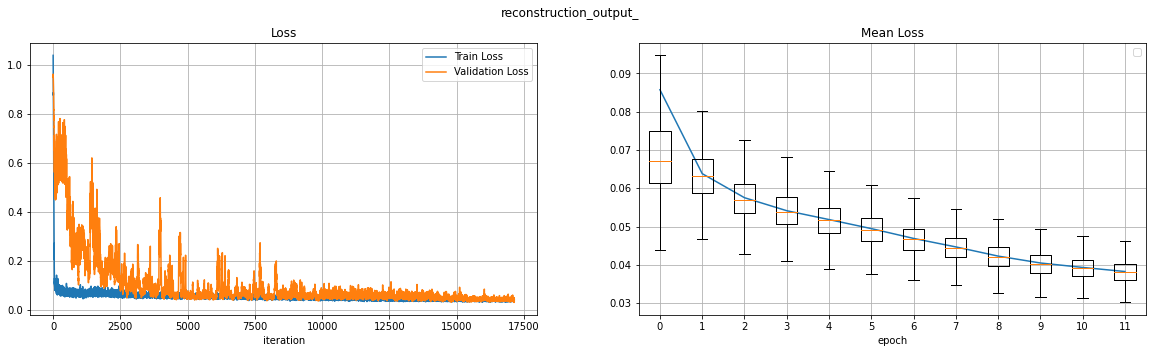

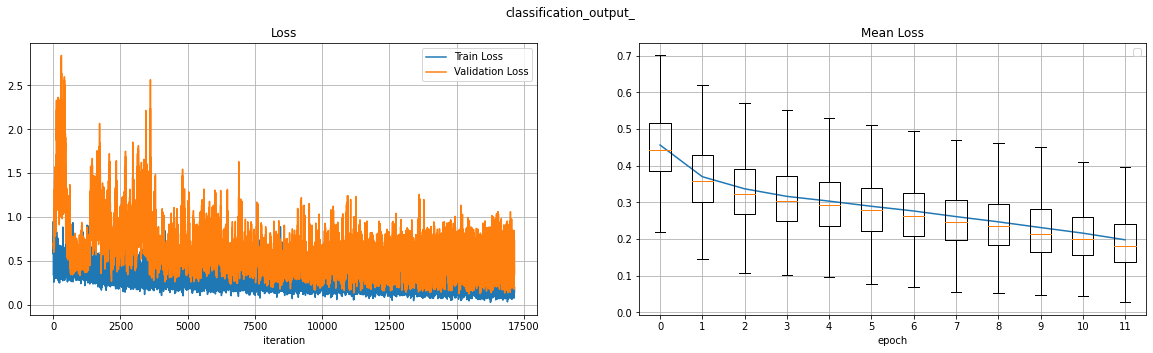

In [12]:
cbir.train()